# OpenEO batch jobs
If you want to cover a larger time window or geographical area, the synchronous ```DataCube.download()``` request can take longer, because more data is being processed on the backend.<br> 
This increases the risk for timeouts or other network issues.

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import sys
import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

Therefore it is recommended to use batch jobs instead of synchronous execution for "large" requests (in terms of temporal or geographical coverage).<br>
Let's illustrate this with a time window of several years.

In [3]:
con  = openeo.connect("https://openeo.vito.be").authenticate_oidc(provider_id="egi")
dates = ("2018-01-01", "2021-03-20")

#load the fields for which we want to extract the time series
with open("fields.geojson") as f:
    features = json.load(f)["features"]
    fields = shapely.geometry.GeometryCollection([shapely.geometry.shape(ftr["geometry"]) for ftr in features])

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=["B04", "B08", "SCL"])
cube = cube.filter_temporal(dates)

#define the masking kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

#get the scene classification
classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5)) #only select the vegetation and bare soil classes
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

#Red, NIR, and NDVI calculation
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

#obtain the masked NDVI time series
masked_ndvi = ndvi.mask(mask)
masked_timeseries = masked_ndvi.aggregate_spatial(geometries=fields, reducer="mean")

# We want to download the result in JSON format, which we have to specify here
masked_timeseries = masked_timeseries.save_result(format="JSON")

Authenticated using refresh token.


## Submitting a batch job
We can now submit this as a batch job.

In [4]:
job = masked_timeseries.send_job()
job.status()

'created'

The job is only created at the backend, so it is not started automatically. We have to start it explicitly.

In [5]:
job.start_job()
job.status()

'queued'

We now have to wait for the job status to become "finished". <br>
The openEO Python Client Library provides a way to actively wait for that. But first we will stop the job we started.

In [6]:
job.stop_job()
job.status()

'canceled'

The ```DataCube.execute_batch``` helper method allows you to execute your algorithm as a batch job, taking care of submitting and starting it, polling its status regularly, and actively waiting till it is finished or failed.

In [7]:
job = masked_timeseries.execute_batch()

0:00:00 Job '000b489c-a794-4433-a449-eafeaed40846': send 'start'
0:00:38 Job '000b489c-a794-4433-a449-eafeaed40846': queued (progress N/A)
0:00:43 Job '000b489c-a794-4433-a449-eafeaed40846': queued (progress N/A)
0:00:50 Job '000b489c-a794-4433-a449-eafeaed40846': queued (progress N/A)
0:00:59 Job '000b489c-a794-4433-a449-eafeaed40846': queued (progress N/A)
0:01:09 Job '000b489c-a794-4433-a449-eafeaed40846': queued (progress N/A)
0:01:22 Job '000b489c-a794-4433-a449-eafeaed40846': queued (progress N/A)
0:01:38 Job '000b489c-a794-4433-a449-eafeaed40846': queued (progress N/A)
0:01:58 Job '000b489c-a794-4433-a449-eafeaed40846': queued (progress N/A)
0:02:23 Job '000b489c-a794-4433-a449-eafeaed40846': running (progress N/A)
0:02:53 Job '000b489c-a794-4433-a449-eafeaed40846': running (progress N/A)
0:03:32 Job '000b489c-a794-4433-a449-eafeaed40846': running (progress N/A)
0:04:19 Job '000b489c-a794-4433-a449-eafeaed40846': finished (progress N/A)


After finalization we can download the result.<br>
Note that a batch job can have multiple output files (assets), which is another advantage compared to synchronous download (which can only have a single result asset).

In [8]:
results = job.get_results()

This results object (```JobResults```), contains some metadata about the job result, for example on the bounding box.

In [9]:
results.get_metadata()["bbox"]

[5.053553857094518, 51.21689628072789, 5.085732850338428, 51.23646091560258]

The list of assets that can be downloaded is also defined.

In [11]:
print(results.get_assets())

[<ResultAsset 'out' (type application/json) at 'https://openeo.vito.be/openeo/1.0/jobs/000b489c-a794-4433-a449-eafeaed40846/results/out'>]
<JobResults for job '000b489c-a794-4433-a449-eafeaed40846'>


There is just one asset, so we can easily download it and plot the multi-year time series, after defining the ```plot_timeseries``` function.

In [15]:
DEFAULT_FIGSIZE = (5, 4)

def plot_timeseries(filename):
    """Helper to plot the timeseries directly from JSON file"""
    with open(filename) as f:
        ts = timeseries_json_to_pandas(json.load(f)).dropna()
    
    ts.index = pd.to_datetime(ts.index)
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ts.plot(marker='o', ax=ax)
    ax.set_title("Average NDVI"); 
    ax.set_ylabel("NDVI");
    ax.set_ylim(-0.05, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

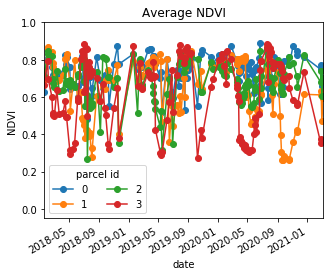

In [16]:
results.download_file("timeseries-large.json")
plot_timeseries("timeseries-large.json")

In this multi-year view on NDVI timeseries we can observe the seasonal cycles and ploughing/harvesting operations.